In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import pprint
import scipy
import tensorflow as tf

from sklearn.model_selection import train_test_split
from edward.models import Bernoulli, Dirichlet, Normal, MultivariateNormalTriL

In [2]:
class FLAGS:
    M=60   # Number of questions
    D=3     # Number of features
    # length-M vector representing number of cutpoints per question
#     N_CUT_VEC = np.repeat(5, M)
    N_CUT_VEC = np.repeat(np.arange(3, 7)[:,np.newaxis], 15, axis=1).T.reshape(-1)

In [3]:
def build_toy_dataset(N, D, noise_std=1, max_level_vec=FLAGS.N_CUT_VEC):
    X = np.random.uniform(-6, 6, size=(N, D))
    w = np.random.uniform(-1, 1, size=D)
    epsilon = np.random.normal(0, noise_std, size=N)
    
    # levels will be 0, 1, ..., max_level per question
    max_level = max_level_vec.max()
    levels = np.array(range(max_level))

    # note this is not generated from ordered logit model
    thresholds = levels[:,np.newaxis]
    logits = np.dot(X, w) + epsilon
    y = (logits > thresholds).astype(int).sum(axis=0)
    # level is the last TRUE in each row, which is also the row sum
    # now clip to maximum level per question
    y = np.round(np.clip(y, 0, max_level_vec)).astype(int)
    
    return X, y

def get_indicators(N, prob_std=0.5):
    ind = np.random.binomial(1, prob_std, N)
    return ind

def logit(p):
    return tf.log(p / (1-p))

In [4]:
from edward.models import RandomVariable
from tensorflow.python.framework import dtypes
from tensorflow.contrib.distributions import Distribution, NOT_REPARAMETERIZED

# Inputs are matrices, but value of random variable is a vector 
# whose length is the number of revealed entries (data_size).
# This is to accommodate a different number of cutpoints per question.
class distributions_OrdinalLogit(Distribution):
    def __init__(self, logits, cutpoints, indicators, name="OrdinalLogit"):
        self._logits = logits  # N x K tensor
        self._cutpoints = cutpoints  # K x max(N_CUT_VEC) tensor
        self._indicators = indicators  # N x K tensor
        
        parameters = dict(locals())
        super(distributions_OrdinalLogit, self).__init__(
            dtype=dtypes.int32,
            reparameterization_type=NOT_REPARAMETERIZED,
            validate_args=False,
            allow_nan_stats=True,
            parameters=parameters,
            graph_parents=[self._logits, self._cutpoints, self._indicators],
            name=name
        )

    def _cumul_probs(self):
        # form a N x K x max(N_CUT_VEC) tensor representing sum of logits and cutpoints
        # use broadcasting
        logits_with_cutpoints = tf.expand_dims(self._logits, -1) + tf.expand_dims(self._cutpoints, 0)
        # now subset to a data_size x max(N_CUT_VEC) array using indicators
        select_logits_with_cutpoints = tf.boolean_mask(logits_with_cutpoints, self._indicators)
        return tf.sigmoid(select_logits_with_cutpoints)  # data_size x max(N_CUT_VEC)
        
    def _log_prob(self, value):        
        cumul_probs = self._cumul_probs()
        data_size = tf.shape(cumul_probs)[0]
        level_probs = tf.concat([cumul_probs, tf.expand_dims(tf.ones([data_size]), -1)], axis=1) - \
                        tf.concat([tf.expand_dims(tf.zeros([data_size]), -1), cumul_probs], axis=1)
        levels = value
        indices_2d = tf.transpose(tf.stack([tf.range(data_size), levels]))  # n x 2
        selected_probs = tf.gather_nd(level_probs, indices_2d)
        
        return tf.reduce_sum(tf.log(selected_probs))
    
    def _sample_n(self, n, seed=None):
        cumul_probs = self._cumul_probs()
        data_size = tf.shape(cumul_probs)[0]
        new_shape = [n, data_size]
        sample_probs = tf.expand_dims(tf.random_uniform(new_shape), -1)
        booleans = tf.greater(sample_probs, cumul_probs)  # using broadcasting
        samples = tf.reduce_sum(tf.cast(booleans, dtype=dtypes.int32), axis=-1)
        return samples
    
    def mean(self):
        # Using the identity that the mean is \sum_{i=0}^k P(X > i)
        cumul_probs = self._cumul_probs()
        means = tf.reduce_sum(1-cumul_probs, axis=1)
        return means
        

def __init__(self, *args, **kwargs):
    RandomVariable.__init__(self, *args, **kwargs)

_name = 'OrdinalLogit'
_candidate = distributions_OrdinalLogit
__init__.__doc__ = _candidate.__init__.__doc__
_globals = globals()
_params = {'__doc__': _candidate.__doc__,
           '__init__': __init__,
           'support': 'countable'}
_globals[_name] = type(_name, (RandomVariable, _candidate), _params)

In [5]:
ed.set_seed(2019)

# DATA
X_all, y_all = build_toy_dataset(FLAGS.M, FLAGS.D)
I_train = get_indicators(FLAGS.M).astype(bool)
y_train = y_all[I_train]

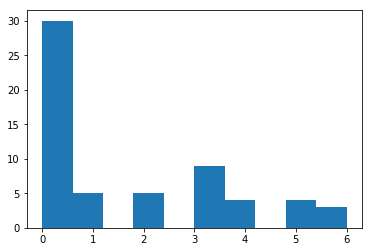

In [6]:
plt.hist(y_all)
plt.show()

In [7]:
# MODEL
X = tf.placeholder(tf.float32, [FLAGS.M, FLAGS.D])
w = Normal(loc=tf.zeros(FLAGS.D), scale=tf.ones(FLAGS.D))
I = tf.placeholder(tf.float32, [1, FLAGS.M])

logits = tf.expand_dims(ed.dot(X, w), 0)

# Using Dirichlet prior to define cutpoints, per rstanarm:
# https://cran.r-project.org/web/packages/rstanarm/vignettes/polr.html
all_ones = tf.ones(shape=(FLAGS.N_CUT_VEC.size, FLAGS.N_CUT_VEC.max()+1), dtype=dtypes.int64)
all_zeros = tf.zeros(shape=all_ones.shape, dtype=dtypes.int64)
range_per_row = tf.cumsum(all_ones, axis=1) - 1
keep_one_mask = tf.less_equal(range_per_row, tf.expand_dims(FLAGS.N_CUT_VEC, 1))
# inflate concentration parameters to get closer to uniform
# if we don't reduce noise this way, ELBO optimization may not converge
conc_multiple = 2
concentration = tf.cast(tf.where(keep_one_mask, all_ones * conc_multiple, all_zeros), dtypes.float32)
pi = Dirichlet(concentration)
cumpi = tf.cumsum(pi, axis=1)
cutpoints = logit(tf.minimum(cumpi, 1-1e-6))[:,:-1]

y = OrdinalLogit(
    logits=logits, 
    cutpoints=cutpoints,
    indicators=I)

# INFERENCE
# Using MAP inference as Laplace inference results in NaN errors,
# probably due to random initialization of qw covariance matrix
qw = ed.models.PointMass(params=tf.Variable(tf.zeros(FLAGS.D)))
inference = ed.MAP({w: qw}, data={X: X_all, y: y_train, I: I_train[np.newaxis,:]})
inference.initialize(n_print=10, n_iter=600)
inference.run()


/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 23.832


In [8]:
qw.eval()

array([-0.7688644, -0.9285711, -0.4510173], dtype=float32)

In [9]:
# y.log_prob requires argument of length y
# construct a new variable representing candidate from y_rest
# compute likelihood with autodiff

X = tf.placeholder(tf.float32, [1, FLAGS.D])
w = tf.placeholder(tf.float32, [FLAGS.D])
single_q_cutpoints = tf.placeholder(tf.float32, [1, cutpoints.shape[1].value])
y = OrdinalLogit(
    logits=tf.matmul(X, tf.expand_dims(w, -1)), 
    cutpoints=single_q_cutpoints,
    indicators=tf.ones((1, 1))
)

In [10]:
y_next = tf.get_variable("y_next", [1], dtype=dtypes.int32)

In [11]:
y_next_hess = tf.hessians(y.log_prob(y_next.value()), w)[0]

In [12]:
w_map = qw.mean().eval()

In [13]:
# observed Fisher information, see https://en.wikipedia.org/wiki/Observed_information
def new_point_info(X_new, y_new, cutpoints):
    return -y_next_hess.eval(feed_dict={X: X_new, w: w_map, single_q_cutpoints: cutpoints, y_next: y_new})

# actual Fisher information (expectation taken over y_new)
# TODO: make this more efficient (e.g. don't run all calls to new_point_info in separate sessions)
def new_point_info_expected(X_new, max_level, cutpoints):
    # integrate out y_next
    cumul_probs = y._cumul_probs().eval(feed_dict={X: X_new, w: w_map, single_q_cutpoints: cutpoints})[0]
    probs = np.append(cumul_probs, 1) - np.append(0, cumul_probs)
    levels = np.arange(max_level+1)
    info_per_level = np.array([new_point_info(X_new, [level], cutpoints) for level in levels])
    return np.sum(probs[:(max_level+1),np.newaxis,np.newaxis] * info_per_level, axis=0)

# # Surprise! This implementation is actually slower
# def new_point_info_expected(X_new, max_level, cutpoints):
#     # integrate out y_next
#     cumul_probs = y._cumul_probs()[0]
#     probs = tf.concat([cumul_probs, [1]], axis=0) - tf.concat([[0], cumul_probs], axis=0)
    
#     y_next_all = [tf.Variable(tf.zeros(1, dtype=dtypes.int32)) for i in range(max_level+1)]
#     y_next_hess_all = [tf.hessians(y.log_prob(y_next_all[i].value()), w)[0]
#                    for i in range(max_level+1)]
#     new_point_info_all = -tf.stack(y_next_hess_all)
#     expected_info = tf.reduce_sum(
#         tf.expand_dims(tf.expand_dims(probs[:(max_level+1)],1),1) * new_point_info_all,
#         axis=0)
    
#     feed_dict = {X: X_new, w: w_map, single_q_cutpoints: cutpoints}
#     feed_dict.update({y_next: [level] for level, y_next in enumerate(y_next_all)})
#     return expected_info.eval(feed_dict=feed_dict)

## TODO: should initialize to the prior precision
obs_fisher = np.zeros((FLAGS.D, FLAGS.D))
obs_idx = np.where(I_train)[0]
for i in obs_idx:
    cutpoints_i = cutpoints[i].eval()[np.newaxis,:]
    obs_fisher += new_point_info(X_all[[i]], y_all[[i]], cutpoints_i)

In [14]:
obs_fisher / I_train.sum()

array([[ 0.89906835, -0.40658859,  0.14962822],
       [-0.4065885 ,  1.15278743, -0.48966041],
       [ 0.14962824, -0.48966049,  1.13272203]])

In [15]:
# Now let's implement item selection.

In [16]:
from collections import namedtuple

OptCriteria = namedtuple('OptCriteria', ['trace', 'logdet', 'max_eigval'])

# Lambda is the precision matrix
# return measures of the variance, Lambda^{-1}
def compute_opt_criteria(Lambda):
    eigvals_Lambda = np.linalg.eigvals(Lambda)
    # When there are not enough previous questions for full rank,
    # some eigenvalues will be 0. Ensure numerical stability here.
    # Originally chose threshold 1e-8, but sometimes an eigenvalue
    # that should've been 0 exceeded this threshold.
    # TODO: handle in a safer way.
    eigvals_Lambda[eigvals_Lambda < 1e-6] = 1e-6
    eigvals_Var = 1.0 / eigvals_Lambda
    return OptCriteria(
        trace = np.sum(eigvals_Var),
        logdet = np.sum(np.log(eigvals_Var)),
        max_eigval = np.max(eigvals_Var)
    )

opt_criteria_comparators = dict(
    A = lambda o1, o2: o1.trace - o2.trace,
    D = lambda o1, o2: o1.logdet - o2.logdet,
    E = lambda o1, o2: o1.max_eigval - o2.max_eigval
)

def cmp_criteria_for(optimality_type):
    return opt_criteria_comparators[optimality_type]


In [17]:
Lambda_prev = obs_fisher
best_new, best_opt_criteria = None, None
cmp_criteria = cmp_criteria_for('A')

unobs_idx = np.where(~I_train)[0]
for i in unobs_idx:
    X_cand = X_all[[i]]
    max_level = FLAGS.N_CUT_VEC[i]
    cutpoints_i = cutpoints[i].eval()[np.newaxis,:]
    Lambda_cand = Lambda_prev + new_point_info_expected(X_cand, max_level, cutpoints_i)
    opt_criteria = compute_opt_criteria(Lambda_cand)
    
    if best_opt_criteria is None or cmp_criteria(opt_criteria, best_opt_criteria) < 0:
        best_new = i
        best_opt_criteria = opt_criteria

In [18]:
best_new, X_all[[best_new]], y_all[[best_new]]

(30, array([[-5.84776736,  3.61137122,  2.59459346]]), array([0]))